In [2]:
%pip install skforecast

     |████████████████████████████████| 386 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 4.7 MB/s eta 0:00:011
     |████████████████████████████████| 365 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 224 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 5.1 MB/s eta 0:00:011
     |████████████████████████████████| 297 kB 6.9 MB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently tak

In [13]:
%pip install --upgrade typing extensions

     |████████████████████████████████| 78 kB 1.5 MB/s eta 0:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=285f5c9ac2636855abdcab9049635dec838ca30d5a567f100b4cfdefdf1fd570
  Stored in directory: /home/pc/.cache/pip/wheels/fa/17/1f/332799f975d1b2d7f9b3f33bbccf65031e794717d24432caee
  Created wheel for extensions: filename=extensions-0.4-py3-none-any.whl size=16387 sha256=9656a5dcee5aa6aa43d80ab75379d50948d5a5906a03e3d9bd5d2af2e6b616b5
  Stored in directory: /home/pc/.cache/pip/wheels/26/fd/ba/404b849f22380952092f9863451135416a5b615095bb2e1c8e
Successfully built typing extensions
Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 1.7 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install --upgrade skforecast

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# **Import CSV data**

In [3]:
# Paths
abonado_path = '../data/abonado.csv'
cliente_path = '../data/cliente.csv'
contador_path = '../data/contador.csv'
caudales_path = '../data/caudales.csv'
gis_path = '../data/gis.csv'
clima_path = '../data/clima.csv'

In [4]:
df_abonado = pd.read_csv(abonado_path)
df_cliente = pd.read_csv(cliente_path)
df_contador = pd.read_csv(contador_path)
df_caudales = pd.read_csv(caudales_path)
df_gis = pd.read_csv(gis_path)
df_clima = pd.read_csv(clima_path)

# **Prediction Class**

La función **transf** transforma limpia y junta los datos de un sector contando las fechas de 2021 y 2022

In [5]:
def transf (Sector: int, dataframe : pd.DataFrame=None):
    # Si el dataframe a insertar esta vacío entonces se inserta solo
    if dataframe is None:
        dataframe = df_caudales #pd.read_csv(caudales_path)

    # Filtramos por Sector
    dataframe = dataframe.loc[(dataframe["Canonical"]=="CAUDAL") & (dataframe["Sector_Neta"]==Sector)]

    print("Tamaño: ",dataframe.shape)

    # Extraemos la fecha aparte #################### CHECAR LA FECHA QUE VIENE AHÍ MARCADA #######################
    dataframe['fecha'] = dataframe['RowKey'].str.extract('([0-9]{4}-[0-9]{2}-[0-9]{2})') #########################
    #dataframe = dataframe.loc[(dataframe["fecha"].str.startswith(Fecha))]
    
    print(dataframe.info())

    print("Tamaño despues de filtrar: ", dataframe.shape)

    # Extraemos la hora aparte #################### CHECAR LA HORA QUE VIENE AHÍ MARCADA #######################
    dataframe['hora']=dataframe['RowKey'].str.extract('([0-9]{2}:[0-9]{2}:[0-9]{2})') ##########################

    # Convertimos la fecha en formato date
    dataframe['fecha'] = pd.to_datetime(dataframe['fecha'])

    print("CheckPoint: Date")

    # Hacemos limpieza de los datos del clima que no necesitaremos
    df_clima_clean = df_clima.drop(columns = [
        "wdir","maxt","visibility","wspd","solarenergy","heatindex","cloudcover","mint","datetime","precip","solarradiation",
        "weathertype","snowdepth","sealevelpressure","snow","dew","precipcover","wgust","conditions","windchill","info","locations"])

    # Sacamos la fecha en una columna diferente
    df_clima_clean['fecha'] = df_clima_clean['datetimeStr'].str.extract('([0-9]{4}-[0-9]{2}-[0-9]{2})') #############
    
    # Le ponemos el formato de datetime a la fecha
    df_clima_clean['fecha'] = pd.to_datetime(df_clima_clean['fecha'])
    
    # Sacamos el promedio por fecha de la temperatura y humedad
    df_clima_agrup = df_clima_clean.groupby(["fecha"]).mean()
    
    # Quitamos los index
    df_clima_agrup.reset_index()

    # Juntamos la fecha de los caudales con la del clima
    dataframe = pd.merge(df_clima_agrup,dataframe, on="fecha")

    # Dividimos la fecha en año, mes, dia, dia_semana
    dataframe['ano'] = dataframe['fecha'].dt.year ################################################################
    dataframe['mes'] = dataframe['fecha'].dt.month
    dataframe['dia'] = dataframe['fecha'].dt.day
    dataframe['dia_semana'] = dataframe['fecha'].dt.weekday

    # Renombramos las columnas
    dataframe = dataframe.rename(columns = {"INF_Values":"DATOS","fecha":"FECHA", "hora":"HORA", "ano":"AÑO","mes":"MES","dia":"DIA","dia_semana":"DIA_SEMANA"})

    # Convertimos la hora en formato de fecha
    dataframe['HORA'] = pd.to_datetime(dataframe['HORA'])

    # Sacamos la hora y minuto de la columna hora
    dataframe['HORA_NUMERICA'] = pd.to_datetime(dataframe['HORA'], format='%H:%M:%S').dt.hour
    dataframe['MINUTO_NUMERICO'] = pd.to_datetime(dataframe['HORA'], format='%H:%M:%S').dt.minute

    # Eliminamos las columnas que no nos interesa para los datos
    dataframe = dataframe.drop(columns = (["Canonical","RowKey","INF_Label","STA_Label","Sector_Neta","FECHA","HORA"]))
    dataframe = dataframe.rename(columns= {"INF_Value":"DATO","temp":"TEMP","humidity":"HUMEDAD"})

    # Eliminamos los datos 0 
    dataframe = dataframe.drop(dataframe[(dataframe['DATO'] == 0)].index)

    return dataframe

A continuación se presenta una clase diseñada que permite realizar todas las tareas de limpieza, entrenamiento y predicción para un sector específico.

In [149]:
# Class
class PredictWaterConsume(object):
    def __init__(self, sector_num):
        self.df_sector = pd.DataFrame(transf(sector_num,))
        self.create_date()
        #df_sector.head()


    def create_date(self):
        X_prueba = self.df_sector.copy()
        X_prueba['FECHA'] = X_prueba['AÑO'].astype(str) + "-"+X_prueba['MES'].astype(str) +"-"+ X_prueba['DIA'].astype(str) + " " + X_prueba['HORA_NUMERICA'].astype(str) + ":" + X_prueba['MINUTO_NUMERICO'].astype(str)
        X_prueba['FECHA'] = pd.to_datetime(X_prueba['FECHA'])
        df_sector_temphum = X_prueba
        #df_sector_temphum.head()

        data = df_sector_temphum.set_index('FECHA')
        self.data = data.sort_index()
        #data
        #self.data = data.asfreq('MS')

        
    ### CHECAR ESA FUNCIÓN PORQUE DE AQUÍ DEPENDE LA SEPARACIÓN DE TEST, TRAIN ###
    #def subset_mes(self, year, month):
        # Subset de datos (mes)
    #    self.subset = self.data[(self.data.index.strftime('%Y-%m').str.startswith('{}-{}'.format(year, month)))]
        #df_cau_agosto
    #    self.subset = self.subset.drop(["AÑO","MES","DIA","DIA_SEMANA","HORA_NUMERICA","MINUTO_NUMERICO"], axis=1)

    def split_data(self, steps=900):
        self.datos_train = self.data[:-steps].drop(["AÑO","MES","DIA","DIA_SEMANA","HORA_NUMERICA","MINUTO_NUMERICO"], axis=1)
        self.datos_test  = self.data[-steps:].drop(["AÑO","MES","DIA","DIA_SEMANA","HORA_NUMERICA","MINUTO_NUMERICO"], axis=1)        
    
    def train(self, steps=900, _lags_=144):
        # Separación datos train-test
        # ==============================================================================
        #steps = 900
        ##self.datos_train = self.data[:-steps]
        ##self.datos_test  = self.data[-steps:]

        print(f"Fechas train : {self.datos_train.index.min()} --- {self.datos_train.index.max()}  (n={len(self.datos_train)})")
        print(f"Fechas test  : {self.datos_test.index.min()} --- {self.datos_test.index.max()}  (n={len(self.datos_test)})")

        fig, ax = plt.subplots(figsize=(7, 3))
        self.datos_train['DATO'].plot(ax=ax, label='train')
        self.datos_test['DATO'].plot(ax=ax, label='test')
        ax.legend();

        # Crear y entrenar forecaster
        # ==============================================================================
        self.forecaster = ForecasterAutoreg(
                        regressor = RandomForestRegressor(),
                        lags = _lags_ # 144
                    )
        y = self.datos_train['DATO']
        self.forecaster.fit(y)
        #forecaster


    def predict(self, steps=900):
        # Predicciones
        # ==============================================================================
        #steps = 900
        predicciones = self.forecaster.predict(steps=steps)
        predicciones.head(5)

        
        sub = self.datos_test['DATO'][:steps] ################################################
        predicciones.index = pd.Index(sub.index) ######################################

        predicciones.head()


        # Gráfico Predicciones
        # ==============================================================================
        fig, ax = plt.subplots(figsize=(15, 8))
        self.datos_train['DATO'][-steps:].plot(ax=ax, label='train')
        sub.plot(ax=ax, label='test')
        predicciones.plot(ax=ax, label='predicciones')
        ax.legend();

        return predicciones
 
    def get_error():
        # Error test
        # ==============================================================================
        error_mse = mean_squared_error(
                        y_true = datos_test['DATO'],
                        y_pred = predicciones
                    )

        print(f"Error de test (mse): {error_mse}")

        error_r2_score = r2_score(
                        y_true = datos_test['DATO'],
                        y_pred = predicciones
        )
        print(f"r2_score: {error_r2_score}")

In [ ]:
## Función predict

## Prueba con Valladolid

In [150]:
mm = PredictWaterConsume(22120000)

Tamaño:  (47534, 6)


/tmp/ipykernel_6985/2786759899.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['fecha'] = dataframe['RowKey'].str.extract('([0-9]{4}-[0-9]{2}-[0-9]{2})') #########################
/tmp/ipykernel_6985/2786759899.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['hora']=dataframe['RowKey'].str.extract('([0-9]{2}:[0-9]{2}:[0-9]{2})') ##########################
/tmp/ipykernel_6985/2786759899.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47534 entries, 21933 to 941387
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Canonical    47534 non-null  object 
 1   RowKey       47534 non-null  object 
 2   INF_Label    47534 non-null  object 
 3   INF_Value    47534 non-null  float64
 4   STA_Label    47534 non-null  object 
 5   Sector_Neta  47534 non-null  int64  
 6   fecha        47534 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.9+ MB
None
Tamaño despues de filtrar:  (47534, 7)
CheckPoint: Date


In [151]:
mm.split_data(21988)

In [152]:
print(mm.datos_train.shape)
print(mm.datos_test.shape)

(23540, 3)
(21988, 3)


In [153]:
mm.datos_test.head() # podemos predecir desde el 3 de abril hasta el último día del año 2022

,TEMP,HUMEDAD,DATO
FECHA,,,
2022-04-04 00:00:00,8.466667,60.563333,25.6
2022-04-04 00:15:00,8.466667,60.563333,22.0
2022-04-04 00:30:00,8.466667,60.563333,22.0
2022-04-04 00:45:00,8.466667,60.563333,20.8
2022-04-04 01:00:00,8.466667,60.563333,20.4


Fechas train : 2021-08-01 00:15:00 --- 2022-04-03 23:45:00  (n=23540)
Fechas test  : 2022-04-04 00:00:00 --- 2022-12-12 06:00:00  (n=21988)


/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


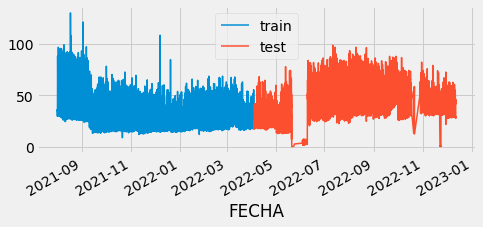

In [154]:
mm.train()

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


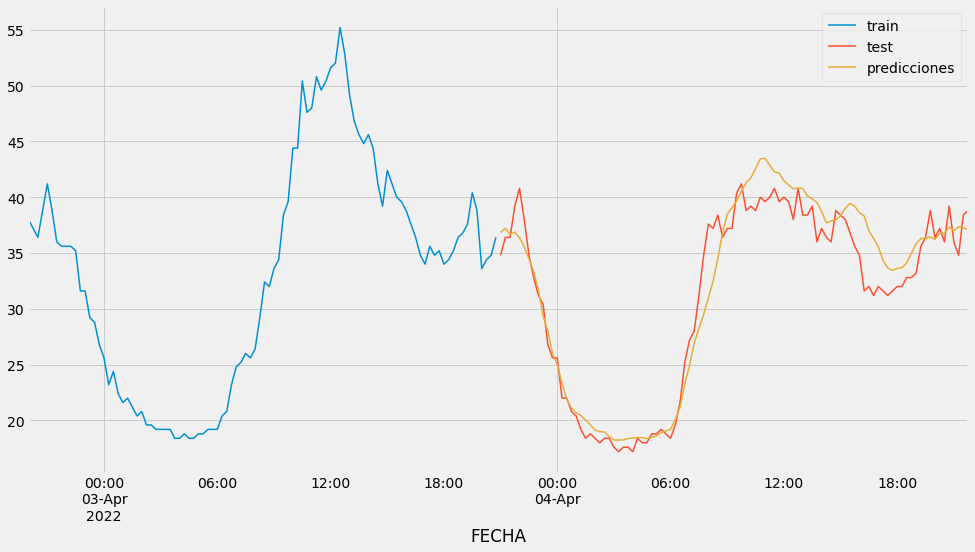

In [122]:
pp = mm.predict(steps=100)

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


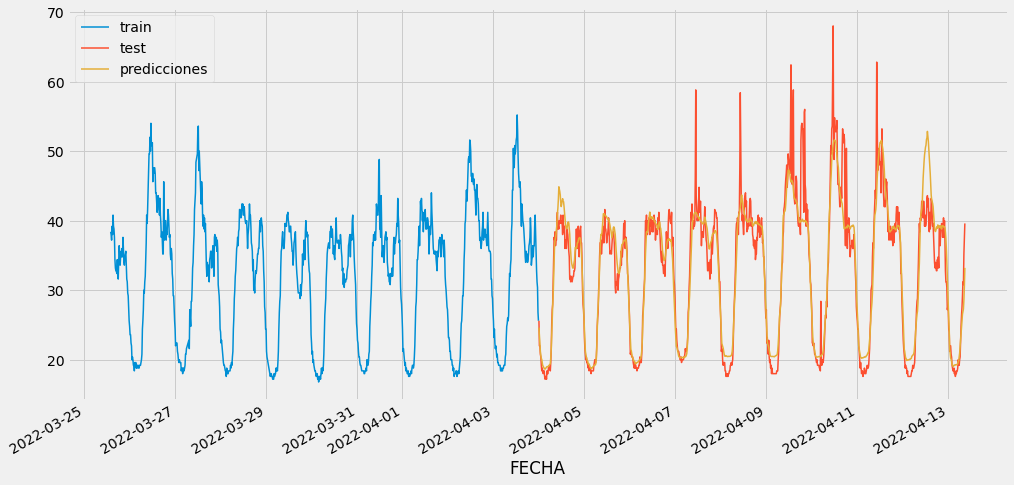

In [155]:
pp2 = mm.predict(steps=900)

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


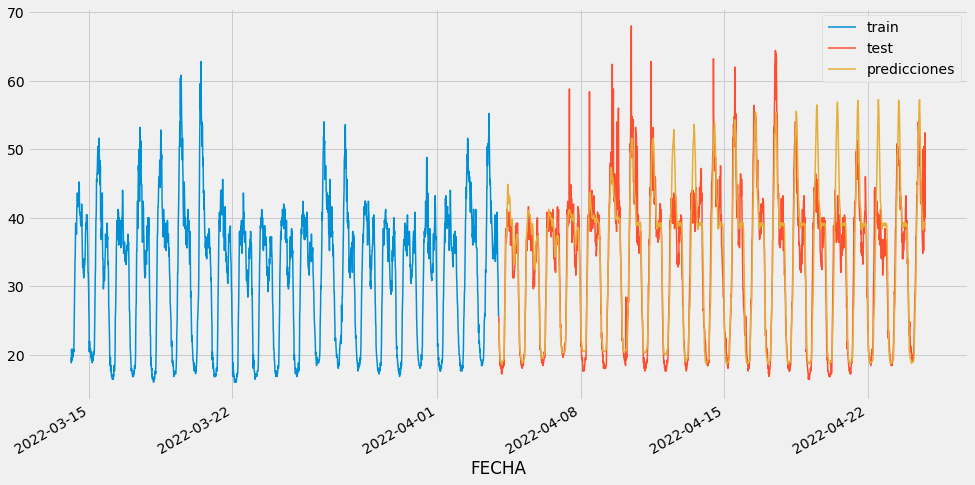

In [156]:
pp3 = mm.predict(steps=2000)

In [157]:
pp3.head()

FECHA
2022-04-04 00:00:00    24.620
2022-04-04 00:15:00    23.468
2022-04-04 00:30:00    22.448
2022-04-04 00:45:00    21.228
2022-04-04 01:00:00    20.576
Name: pred, dtype: float64

In [ ]:
# the model is the "self.forecaster"

# **Save model**

In [10]:
import pickle

In [165]:
# save the model to disk
filename = 'valladolid_model.sav'
pickle.dump(mm.forecaster, open(filename, 'wb'))

### REVISAR BIEN PARA QUE QUEDE CORRECTO

In [166]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

## PREDICT FUNCTION


In [175]:
def predict(model, steps=900):
    # Predicciones
    predicciones = model.predict(steps=steps)
    predicciones.head(5)

    # Ésta parte va desde el 4 de abril del 2022 hasta la fecha que dé el usuario
    # datos_test se forma con los datos obtenidos desde el 4 de abril 2022 hasta la fecha que da el usuario
    sub = mm.datos_test['DATO'][:steps] ################################################
    predicciones.index = pd.Index(sub.index) #############################################

    predicciones.head()


    # ESTA PARTE NO ES NECESARIA #########################################################
    # Gráfico Predicciones
    fig, ax = plt.subplots(figsize=(15, 8))
    mm.datos_train['DATO'][-steps:].plot(ax=ax, label='train')
    sub.plot(ax=ax, label='test')
    predicciones.plot(ax=ax, label='predicciones')
    ax.legend();

    return predicciones

In [ ]:
##################################################################################################################

In [171]:
aa = loaded_model.predict(steps=20)

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [163]:
aa.head()

144    24.620
145    23.468
146    22.448
147    21.228
148    20.576
Name: pred, dtype: float64

In [ ]:
##################################################################################################################

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


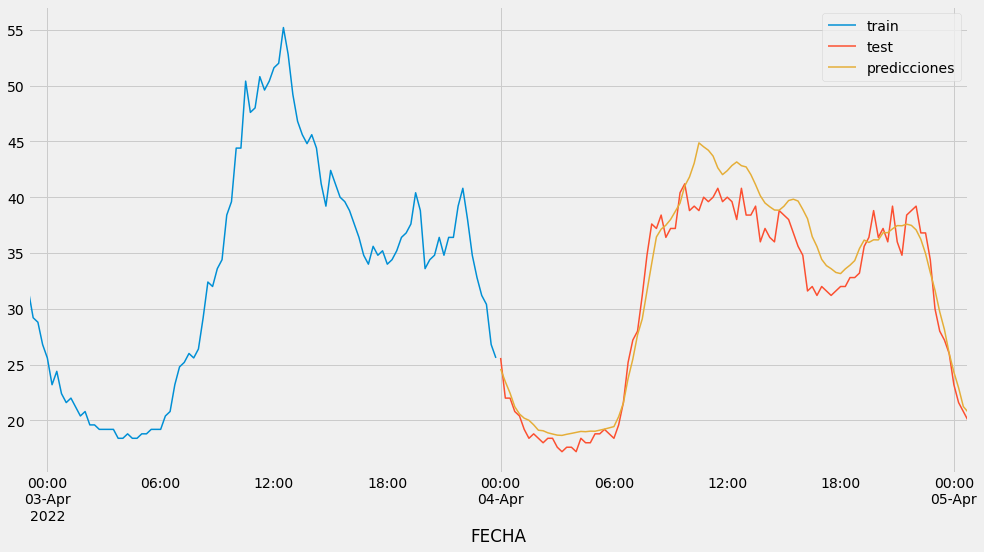

In [177]:
prueba = predict(loaded_model, steps=100)
#aa.index = pd.Index(obj.datos_test[:20].index)
#aa.head()

## DESCUBRIENDO LAS FECHAS QUE SE PUEDEN PREDECIR SIN SEPARAR POR MESES

In [ ]:
# HACER EL CÁLCULO DE CUÁNTOS STEPS SON POR DÍA O DÍAS
# 96 * num_dias + 16 (las 16 son de las últimas horas del 3 de abril) ------ cuadno split 22000
# 96*num_dias + 4

# **SUR ESTE**

In [178]:
mm = PredictWaterConsume(22122000)

Tamaño:  (46326, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46326 entries, 12649 to 1024199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Canonical    46326 non-null  object 
 1   RowKey       46326 non-null  object 
 2   INF_Label    46326 non-null  object 
 3   INF_Value    46326 non-null  float64
 4   STA_Label    46326 non-null  object 
 5   Sector_Neta  46326 non-null  int64  
 6   fecha        46326 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.8+ MB
None
Tamaño despues de filtrar:  (46326, 7)


/tmp/ipykernel_6985/2786759899.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['fecha'] = dataframe['RowKey'].str.extract('([0-9]{4}-[0-9]{2}-[0-9]{2})') #########################
/tmp/ipykernel_6985/2786759899.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['hora']=dataframe['RowKey'].str.extract('([0-9]{2}:[0-9]{2}:[0-9]{2})') ##########################
/tmp/ipykernel_6985/2786759899.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

CheckPoint: Date


In [218]:
mm.split_data(22000)

In [219]:
print(mm.datos_train.shape)
print(mm.datos_test.shape)

(24292, 3)
(22000, 3)


In [220]:
mm.datos_test.head()

,TEMP,HUMEDAD,DATO
FECHA,,,
2022-04-27 00:00:00,15.633333,65.336667,18.96
2022-04-27 00:15:00,15.633333,65.336667,14.32
2022-04-27 00:30:00,15.633333,65.336667,15.16
2022-04-27 00:45:00,15.633333,65.336667,15.20
2022-04-27 01:00:00,15.633333,65.336667,14.84


Fechas train : 2021-08-05 14:00:00 --- 2022-04-26 23:45:00  (n=24292)
Fechas test  : 2022-04-27 00:00:00 --- 2022-12-12 07:00:00  (n=22000)


/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


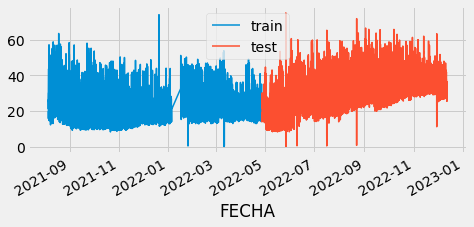

In [221]:
mm.train()

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


FECHA
2022-04-27 00:00:00    18.7416
2022-04-27 00:15:00    17.7980
2022-04-27 00:30:00    16.8516
2022-04-27 00:45:00    16.5640
2022-04-27 01:00:00    16.1932
                        ...   
2022-04-27 23:45:00    20.0056
2022-04-28 00:00:00    18.9536
2022-04-28 00:15:00    17.7624
2022-04-28 00:30:00    17.0108
2022-04-28 00:45:00    16.7072
Name: pred, Length: 100, dtype: float64

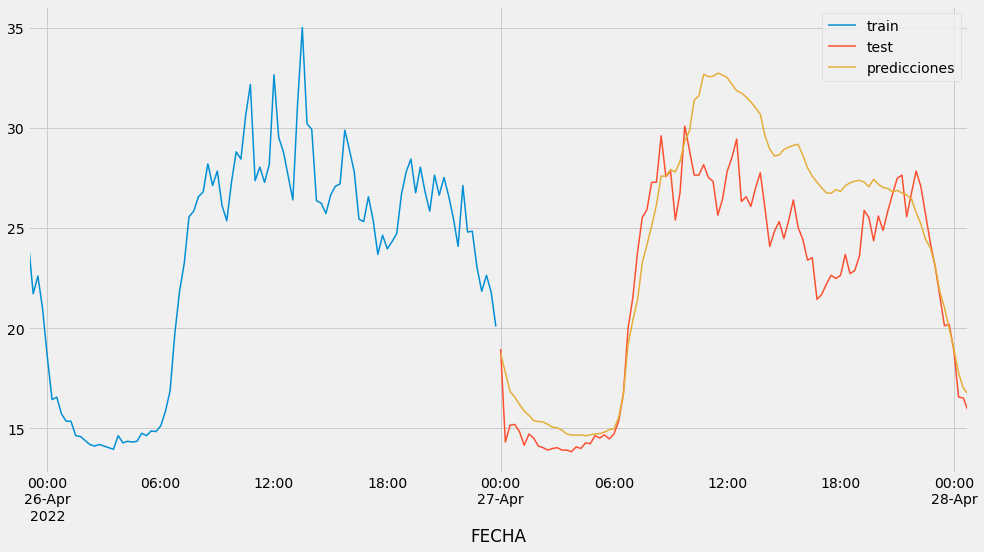

In [222]:
mm.predict(steps=100)

In [223]:
filename = 'sur_este_model.sav'
pickle.dump(mm.forecaster, open(filename, 'wb'))

# **GASOLINERA**

In [224]:
mm2 = PredictWaterConsume(22121000)

Tamaño:  (47326, 6)


/tmp/ipykernel_6985/2786759899.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['fecha'] = dataframe['RowKey'].str.extract('([0-9]{4}-[0-9]{2}-[0-9]{2})') #########################
/tmp/ipykernel_6985/2786759899.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['hora']=dataframe['RowKey'].str.extract('([0-9]{2}:[0-9]{2}:[0-9]{2})') ##########################
/tmp/ipykernel_6985/2786759899.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47326 entries, 4458 to 1015999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Canonical    47326 non-null  object 
 1   RowKey       47326 non-null  object 
 2   INF_Label    47326 non-null  object 
 3   INF_Value    47326 non-null  float64
 4   STA_Label    47326 non-null  object 
 5   Sector_Neta  47326 non-null  int64  
 6   fecha        47326 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.9+ MB
None
Tamaño despues de filtrar:  (47326, 7)
CheckPoint: Date


In [279]:
mm2.split_data(22052)

In [280]:
print(mm2.datos_train.shape)
print(mm2.datos_test.shape)

(23955, 3)
(22052, 3)


In [281]:
mm2.datos_test.head()

,TEMP,HUMEDAD,DATO
FECHA,,,
2022-04-13 00:00:00,13.933333,79.21,3.80
2022-04-13 00:15:00,13.933333,79.21,3.20
2022-04-13 00:30:00,13.933333,79.21,3.44
2022-04-13 00:45:00,13.933333,79.21,3.12
2022-04-13 01:00:00,13.933333,79.21,3.36


Fechas train : 2021-08-05 14:00:00 --- 2022-04-12 23:45:00  (n=23955)
Fechas test  : 2022-04-13 00:00:00 --- 2022-12-12 07:00:00  (n=22052)


/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


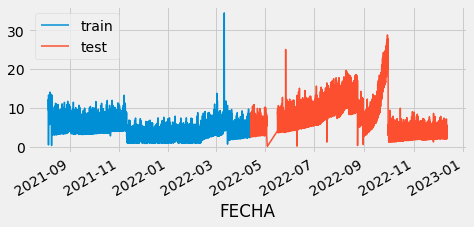

In [282]:
mm2.train()

/home/pc/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:854: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


FECHA
2022-04-13 00:00:00    3.8460
2022-04-13 00:15:00    3.5488
2022-04-13 00:30:00    3.3576
2022-04-13 00:45:00    3.1912
2022-04-13 01:00:00    3.0512
                        ...  
2022-04-13 23:45:00    4.1336
2022-04-14 00:00:00    3.8544
2022-04-14 00:15:00    3.6340
2022-04-14 00:30:00    3.4784
2022-04-14 00:45:00    3.2516
Name: pred, Length: 100, dtype: float64

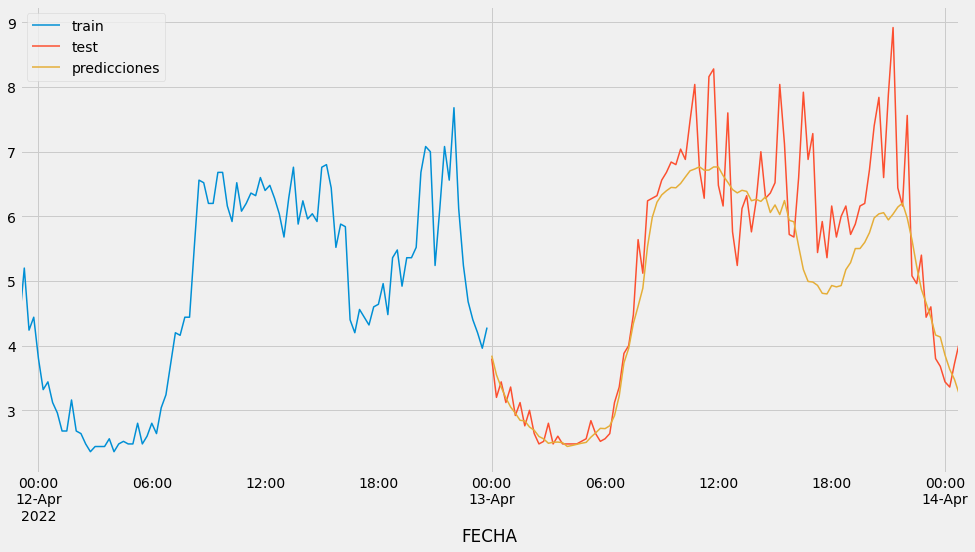

In [283]:
mm2.predict(steps=100)

In [284]:
filename = 'gasolinera_model.sav'
pickle.dump(mm2.forecaster, open(filename, 'wb'))